In [1]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
import glob

# General machine learning packages
from sklearn.model_selection import train_test_split

# Packages related to images
from PIL import Image
import PIL


In [50]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != ' anoniem']
    df = df[df['Creator'] != ' onbekend']
    df = df[df['Creator'].notna()]
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    return df

df = clean_data('D:/MSc scriptie/Data/Rijksmuseum/xml_files.csv')
rijksdata = preprocess_data(df)

In [51]:
rijksdata

,Identifier,Creator,Title,Date,Type
1,SK-A-4877,"Maris, Matthijs",Portret van Jacob Maris,1857 - 1857,schilderij
2,SK-A-4881,"Maes, Nicolaes","Portret van een jonge man, waarschijnlijk Simo...",1675 - 1685,schilderij
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz",Keizer Karel V omgeven door zijn overwonnen te...,1555 - 1555,prent
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz",Gevangename van Frans I tijdens de slag van Pa...,1555 - 1556,prent
5,RP-P-1992-68,"Bos, Balthazar van den",Christus en vrouw van Kanaän,1553 - 1553,prent
...,...,...,...,...,...
111989,RP-P-2011-65-24,"Monnoyer, Jean Baptiste",Boeket in glazen vaas (),ca. 1680 - ca. 1695,prent
111990,RP-P-2011-65-25,"Monnoyer, Jean Baptiste",Boeket in glazen vaas (),ca. 1680 - ca. 1695,prent
111997,RP-T-00-467-13,"Bik, Adrianus Johannes",Gezicht op Stellenbosch; Drakenberg; Simonsber...,1816 - 1816,tekening
112003,RP-P-2012-4,"Visscher, Claes Jansz. (II)",IJsgezicht met zeilende schuit (),ca. 1608 - ca. 1615,prent


In [181]:
#Paths to different folders/files
img_list = glob.glob("D:/MSc scriptie/Data/Rijksmuseum/jpg2/*.jpg")
image_dir = "D:/MSc scriptie/Data/Rijksmuseum/jpg2/"
split_image_dir = "D:/MSc scriptie/Data/Rijksmuseum/jpg2_split/"
test_image_dir = "D:/MSc scriptie/Data/Rijksmuseum/test_set/"
# labels_file = "D:/MSc scriptie/Data/Rijksmuseum/xml_files_no_anons.csv"
training_path = "D:/MSc scriptie/Data/Rijksmuseum/training_data/"
validation_path = "D:/MSc scriptie/Data/Rijksmuseum/validation_data/"

img_size = (200, 200) #Size of the input of the neural networks
IMG_SHAPE = img_size + (3,)
batch_size = 32
n_labels = len(rijksdata.groupby('Creator').count())

In [145]:
# #Paths to different folders/files
# image_dir = "../Data/Rijksmuseum/jpg2"
# resized_img_dir = "..Data/Rijksmuseum/resized_jpg2"

# train_dir = "../Data/Rijksmuseum/train_set"
# test_image_dir = "../Data/Rijksmuseum/test_set"

# training_path = "../Data/Rijksmuseum/training_data/"
# validation_path = "../Data/Rijksmuseum/validation_data/"

# labels_file = "../Data/Rijksmuseum/xml_files.csv"

# img_size = (200, 200) #Size of the input of the neural networks
# IMG_SHAPE = img_size + (3,)
# batch_size = 32
# n_labels = len(rijksdata.groupby('Creator').count())

In [159]:
# labels = pd.read_csv(labels_file)
labels = rijksdata[['Identifier', 'Creator']]
labels

,Identifier,Creator
1,SK-A-4877,"Maris, Matthijs"
2,SK-A-4881,"Maes, Nicolaes"
3,RP-P-1992-35,"Coornhert, Dirck Volckertsz"
4,RP-P-1992-36,"Coornhert, Dirck Volckertsz"
5,RP-P-1992-68,"Bos, Balthazar van den"
...,...,...
111989,RP-P-2011-65-24,"Monnoyer, Jean Baptiste"
111990,RP-P-2011-65-25,"Monnoyer, Jean Baptiste"
111997,RP-T-00-467-13,"Bik, Adrianus Johannes"
112003,RP-P-2012-4,"Visscher, Claes Jansz. (II)"


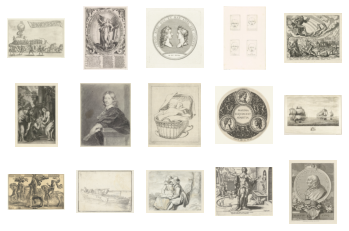

In [149]:
def plot_random_images(img_names, n_x=2, n_y=2, seed=0):
    """
    Plots random images from de data set in a n_x by n_y grid

    :image_names: List with the names of all images
    :n_x: Height of the grid
    :n_x: Width of the grid
    :seed: Seed for the random sample
    :return: nothing
    """ 
    f, axs = plt.subplots(n_x, n_y)
    sample = img_names.sample(n_x * n_y, random_state=seed)
    c = 0
    for x in range(n_x):
        for y in range(n_y):
            img_loc = [item for item in img_list if sample.iloc[c] in item][0]
            img = plt.imread(img_loc)
            axs[x, y].imshow(img)
            axs[x, y].axis('off')
            c += 1

plot_random_images(labels["Identifier"], 3, 5)

# Image size
Most machine learning requires that the input is always of the same size. Because our images are not always of the same size. We have to resize them

In [17]:
# def resize_images(img_names, img_dir, new_img_dir):
#     #Deprecated, replaced by the flow from directory
#     for img in img_names:
#         Image.open(img_dir + "/" + img + ".jpg").resize(img_size).save(new_img_dir + "/" + img + ".jpg")

# resize_images(labels["Identifier"], image_dir, resized_train_dir)

# Split

In [86]:
# X_train, X_test, y_train, y_test = train_test_split(labels["Identifier"].to_numpy(), labels["Creator"].to_numpy(), test_size=0.2, random_state=42)
# X_train

array(['RP-P-1882-A-6509', 'RP-P-1958-478', 'RP-P-OB-55.869', ...,
       'RP-P-OB-76.625', 'SK-A-172', 'RP-T-00-759'], dtype=object)

In [160]:
labels['Creator'].iloc[0]

' Maris, Matthijs'

# Reformat data for learning
To be able to load the data with a generator. We must split the training and validation data and place them into a folder based on their label.

In [183]:
def generate_label_folders(image_path, image_names, image_labels, destination_path):
    """
    Splits a single folder with images into multiple folders where images are placed based on their labels.

    :image_path: path to the folder with the images
    :image_names: A numpy array with the names of all images
    :image_labels: A numpy array with the labels of all images
    :destination_path: Path of the folder where the images are placed into
    :return: Nothing
    """ 
    for i in range(len(image_names)):
        # Check if the directory exists. Else, make one
        isExist = os.path.exists(os.path.join(destination_path, str(image_labels.iloc[i])))
        if not isExist:
            os.makedirs(os.path.join(destination_path, str(image_labels.iloc[i])))
            
        # Copy the image
        img_loc = [item for item in img_list if image_names.iloc[i] in item][0]
        img = Image.open(img_loc)
        img.save(destination_path + "/" + str(image_labels.iloc[i]) + "/" + image_names.iloc[i] + ".jpg")
        

generate_label_folders(image_dir, labels["Identifier"], labels["Creator"], split_image_dir)
# generate_label_folders(image_dir, X_test, y_test, test_image_dir)

KeyboardInterrupt: 